In [1]:
import warnings

import matplotlib as mpl
from IPython import get_ipython

import pymor.tools.random

ip = get_ipython()
if ip is not None:
    ip.run_line_magic('matplotlib', 'inline')

warnings.filterwarnings('ignore', category=UserWarning, module='torch')

pymor.tools.random._default_random_state = None

mpl.rcParams['figure.facecolor'] = (1.0, 1.0, 1.0, 0.0)


Loading pyMOR defaults from file /builds/pymor/pymor/docs/source/pymor_defaults.py


# Tutorial: Interpolatory model order reduction for LTI systems

Here we discuss interpolatory model order reduction methods
(also known as:
moment matching,
Krylov subspace methods, and
Padé approximation)
for LTI systems.
In {doc}`tutorial_lti_systems`, we discussed transfer functions of LTI systems,
which give a frequency-domain description of the input-output mapping and
are involved in system norms.
Therefore, a reasonable approach to approximating a given LTI system is to build
a reduced-order model such that its transfer function interpolates the
full-order transfer function.

We start with simpler approaches
(higher-order interpolation at single point {cite}`G97`) and
then move on to bitangential Hermite interpolation
which is directly supported in pyMOR.

We demonstrate them on
[Penzl's FOM example](https://morwiki.mpi-magdeburg.mpg.de/morwiki/index.php/Penzl%27s_FOM).

In [2]:
from pymor.models.examples import penzl_example

fom = penzl_example()
print(fom)

LTIModel
    class: LTIModel
    number of equations: 1006
    number of inputs:    1
    number of outputs:   1
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(1006)


## Interpolation at infinity

Given an LTI system

```{math}
\begin{align*}
  \dot{x}(t) & = A x(t) + B u(t), \\
  y(t) & = C x(t) + D u(t),
\end{align*}
```

the most straightforward interpolatory method is using Krylov subspaces

```{math}
\begin{align*}
  V
  & =
  \begin{bmatrix}
    B & A B & \cdots & A^{r - 1} B
  \end{bmatrix}, \\
  W
  & =
  \begin{bmatrix}
    C^T & A^T C^T & \cdots & {\left(A^T\right)}^{r - 1} C^T
  \end{bmatrix}
\end{align*}
```

to perform a (Petrov-)Galerkin projection.
This will achieve interpolation of the first $2 r$ moments at infinity
of the transfer function.
The moments at infinity, also called *Markov parameters*,
are the coefficients in the Laurent series expansion:

```{math}
\begin{align*}
  H(s)
  & = C {(s I - A)}^{-1} B + D \\
  & = C \frac{1}{s} {\left(I - \frac{1}{s} A \right)}^{-1} B + D \\
  & = C \frac{1}{s}
    \sum_{k = 0}^{\infty} {\left(\frac{1}{s} A \right)}^{k}
    B + D \\
  & = D + \sum_{k = 0}^{\infty} C A^k B \frac{1}{s^{k + 1}} \\
  & = D + \sum_{k = 1}^{\infty} C A^{k - 1} B \frac{1}{s^{k}}.
\end{align*}
```

The moments at infinity are thus

```{math}
M_0(\infty) = D, \quad
M_k(\infty) = C A^{k - 1} B,  \text{ for } k \geqslant 1.
```

A reduced-order model

```{math}
\begin{align*}
  \dot{\widehat{x}}(t) & = \widehat{A} \widehat{x}(t) + \widehat{B} u(t), \\
  \widehat{y}(t) & = \widehat{C} \widehat{x}(t) + \widehat{D} u(t),
\end{align*}
```

where

```{math}
\widehat{A} = {\left(W^T V\right)}^{-1} W^T A V, \quad
\widehat{B} = {\left(W^T V\right)}^{-1} W^T B, \quad
\widehat{C} = C V, \quad
\widehat{D} = D,
```

with $V$ and $W$ as above, satisfies

```{math}
C A^{k - 1} B
=
\widehat{C} \widehat{A}^{k - 1} \widehat{B}, \quad
k = 1, \ldots, 2 r.
```

We can compute {math}`V` and {math}`W` using the
`arnoldi` function.

In [3]:
from pymor.algorithms.krylov import arnoldi

r_max = 5
V = arnoldi(fom.A, fom.E, fom.B.as_range_array(), r_max)
W = arnoldi(fom.A.H, fom.E.H, fom.C.as_source_array(), r_max)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

We then use those to perform a Petrov-Galerkin projection.

In [4]:
from pymor.reductors.basic import LTIPGReductor

pg = LTIPGReductor(fom, W, V)
roms_inf = [pg.reduce(i + 1) for i in range(r_max)]

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

To compare, we first draw the Bode plots.

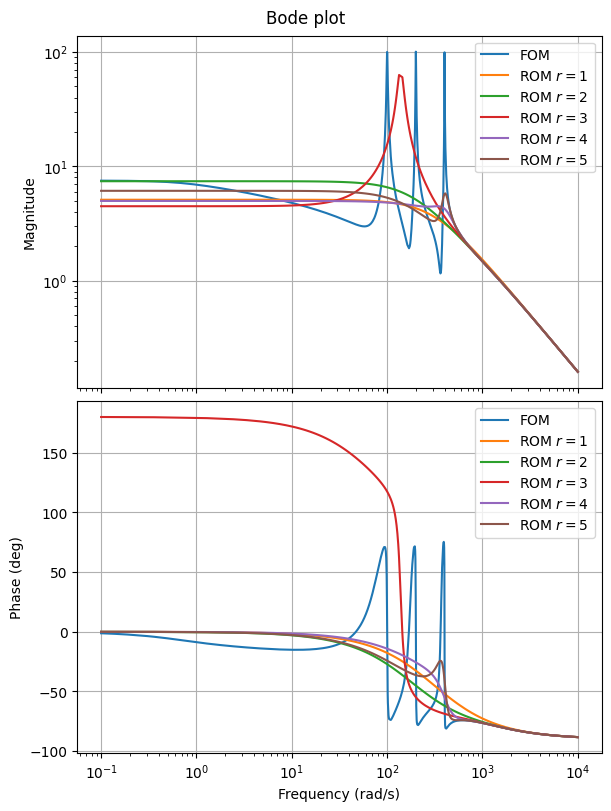

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True

w = (1e-1, 1e4)
bode_plot_opts = dict(sharex=True, squeeze=False, figsize=(6, 8), constrained_layout=True)

fig, ax = plt.subplots(2, 1, **bode_plot_opts)
fom.transfer_function.bode_plot(w, ax=ax, label='FOM')
for rom in roms_inf:
    rom.transfer_function.bode_plot(w, ax=ax, label=f'ROM $r = {rom.order}$')
_ = ax[0, 0].legend()
_ = ax[1, 0].legend()

As expected, we see good approximation for higher frequencies.
Drawing the magnitude of the error makes it clearer.

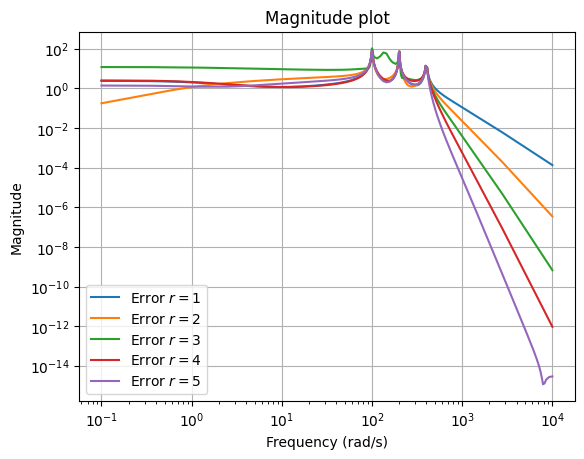

In [6]:
fig, ax = plt.subplots()
for rom in roms_inf:
    err = fom - rom
    err.transfer_function.mag_plot(w, ax=ax, label=f'Error $r = {rom.order}$')
_ = ax.legend()

To check the stability of the ROMs, we can plot their poles and compute the maximum real part.

Maximum real part: -9.324900122511472


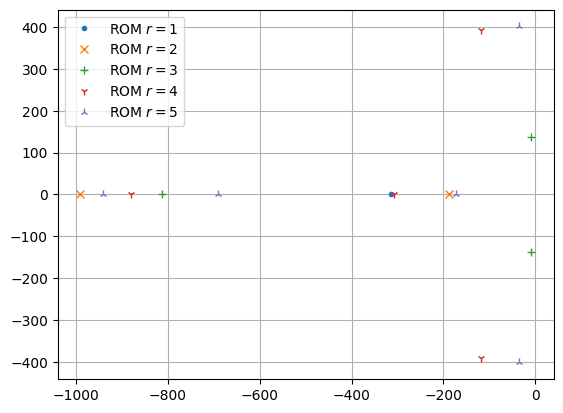

In [7]:
fig, ax = plt.subplots()
markers = '.x+12'
spectral_abscissas = []
for rom, marker in zip(roms_inf, markers):
    poles = rom.poles()
    spectral_abscissas.append(poles.real.max())
    ax.plot(poles.real, poles.imag, marker, label=f'ROM $r = {rom.order}$')
_ = ax.legend()
print(f'Maximum real part: {max(spectral_abscissas)}')

We see that they are all asymptotically stable.

## Interpolation at zero

The next option is using inverse Krylov subspaces
(more commonly called the Padé approximation).

```{math}
\begin{align*}
  V
  & =
  \begin{bmatrix}
    A^{-1} B & A^{-2} B & \cdots & A^{-r} B
  \end{bmatrix}, \\
  W
  & =
  \begin{bmatrix}
    A^{-T} C^T
    & {\left(A^{-T}\right)}^{2} C^T
    & \cdots
    & {\left(A^{-T}\right)}^{r} C^T
  \end{bmatrix}
\end{align*}
```

This will achieve interpolation of the first $2 r$ moments at zero of the
transfer function.

```{math}
\begin{align*}
  H(s)
  & = C {(s I - A)}^{-1} B + D \\
  & = C {\left(A \left(s A^{-1} - I\right)\right)}^{-1} B + D \\
  & = C {\left(s A^{-1} - I\right)}^{-1} A^{-1} B + D \\
  & = -C {\left(I - s A^{-1}\right)}^{-1} A^{-1} B + D \\
  & = -C
    \sum_{k = 0}^{\infty} {\left(s A^{-1} \right)}^{k}
    A^{-1} B + D \\
  & = D - \sum_{k = 0}^{\infty} C A^{-(k + 1)} B s^k.
\end{align*}
```

The moments at zero are

```{math}
\begin{align*}
  M_0(0)
  & = D - C A^{-1} B
  = H(0), \\
  M_k(0)
  & = -C A^{-(k + 1)} B
  = \frac{1}{k!} H^{(k)}(0),
  \text{ for } k \ge 1.
\end{align*}
```

We can again use the `arnoldi` function
to compute {math}`V` and {math}`W`.

In [8]:
from pymor.operators.constructions import InverseOperator

r_max = 5
v0 = fom.A.apply_inverse(fom.B.as_range_array())
V = arnoldi(InverseOperator(fom.A), InverseOperator(fom.E), v0, r_max)
w0 = fom.A.apply_inverse_adjoint(fom.C.as_source_array())
W = arnoldi(InverseOperator(fom.A.H), InverseOperator(fom.E.H), w0, r_max)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Then, in the same way, compute the Petrov-Galerkin projection...

In [9]:
pg = LTIPGReductor(fom, W, V)
roms_zero = [pg.reduce(i + 1) for i in range(r_max)]

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

...and draw the Bode plot.

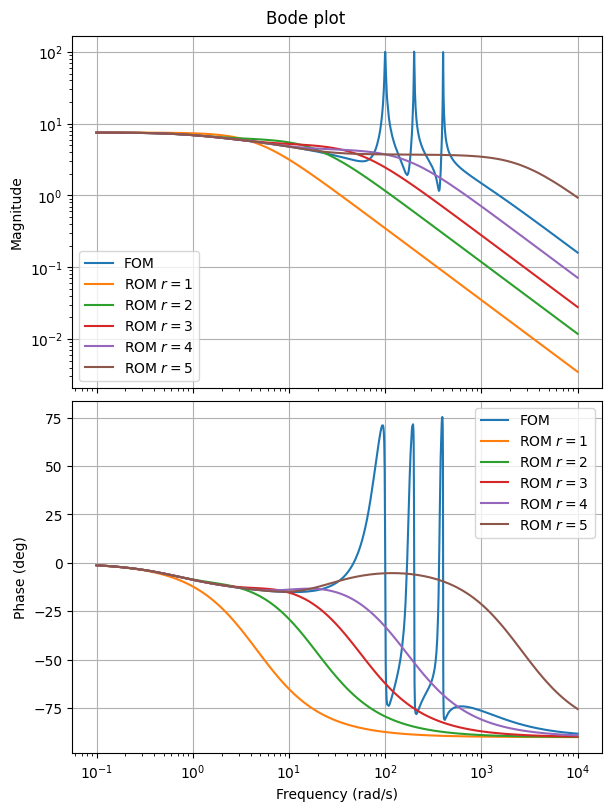

In [10]:
fig, ax = plt.subplots(2, 1, **bode_plot_opts)
fom.transfer_function.bode_plot(w, ax=ax, label='FOM')
for rom in roms_zero:
    rom.transfer_function.bode_plot(w, ax=ax, label=f'ROM $r = {rom.order}$')
_ = ax[0, 0].legend()
_ = ax[1, 0].legend()

Now, because of interpolation at zero, we get good approximation for lower
frequencies.
The error plot shows this better.

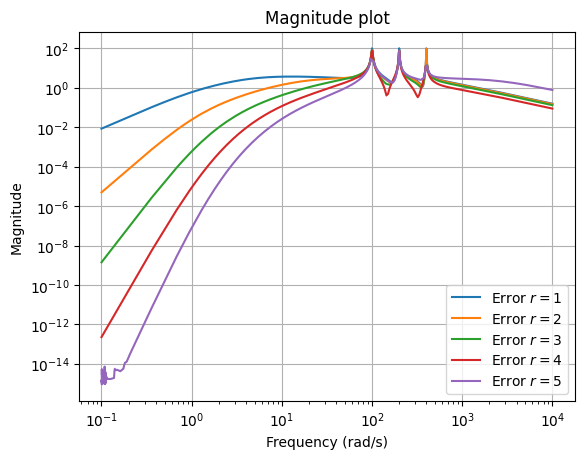

In [11]:
fig, ax = plt.subplots()
for rom in roms_zero:
    err = fom - rom
    err.transfer_function.mag_plot(w, ax=ax, label=f'Error $r = {rom.order}$')
_ = ax.legend()

Checking stability using the poles of the ROMs.

Maximum real part: -1.0000026360387704


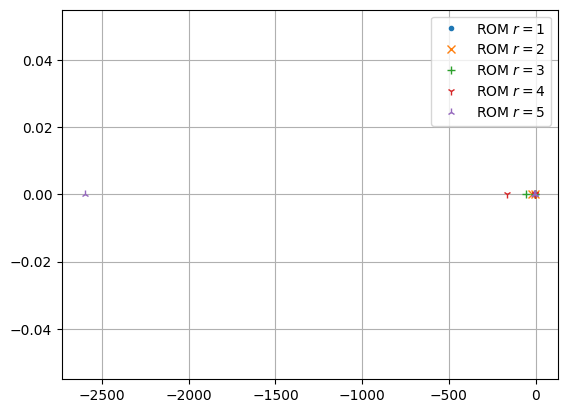

In [12]:
fig, ax = plt.subplots()
spectral_abscissas = []
for rom, marker in zip(roms_zero, markers):
    poles = rom.poles()
    spectral_abscissas.append(poles.real.max())
    ax.plot(poles.real, poles.imag, marker, label=f'ROM $r = {rom.order}$')
_ = ax.legend()
print(f'Maximum real part: {max(spectral_abscissas)}')

The ROMs are again all asymptotically stable.

## Interpolation at an arbitrary finite point

A more general approach is using rational Krylov subspaces
(also known as the shifted Padé approximation).

```{math}
\begin{align*}
  V
  & =
  \begin{bmatrix}
    (\sigma I - A)^{-1} B
    & (\sigma I - A)^{-2} B
    & \cdots
    & (\sigma I - A)^{-r} B
  \end{bmatrix}, \\
  W
  & =
  \begin{bmatrix}
    (\sigma I - A)^{-H} C^T
    & {\left((\sigma I - A)^{-H}\right)}^{2} C^T
    & \cdots
    & {\left((\sigma I - A)^{-H}\right)}^{r} C^T
  \end{bmatrix},
\end{align*}
```

for some $\sigma \in \mathbb{C}$ that is not an eigenvalue of $A$.

This will achieve interpolation of the first $2 r$ moments at {math}`\sigma` of
the transfer function.

```{math}
\begin{align*}
  H(s)
  & = C {(s I - A)}^{-1} B + D \\
  & = C {((s - \sigma) I + \sigma I - A)}^{-1} B + D \\
  & = C
    {\left((\sigma I - A)
      \left((s - \sigma) (\sigma I - A)^{-1} + I\right)\right)}^{-1}
    B + D \\
  & = C
    {\left((s - \sigma) (\sigma I - A)^{-1} + I\right)}^{-1}
    {(\sigma I - A)}^{-1}
    B + D \\
  & = C
    {\left(I - (s - \sigma) (A - \sigma I)^{-1}\right)}^{-1}
    {(\sigma I - A)}^{-1}
    B + D \\
  & = C
    \sum_{k = 0}^{\infty} {\left((s - \sigma) (A - \sigma I)^{-1} \right)}^{k}
    {(\sigma I - A)}^{-1}
    B + D \\
  & = D - \sum_{k = 0}^{\infty} C (A - \sigma I)^{-(k + 1)} B (s - \sigma)^{k}.
\end{align*}
```

The moments at {math}`\sigma` are

```{math}
\begin{align*}
  M_0(\sigma)
  & = C {(\sigma I - A)}^{-1} B + D
  = H(\sigma), \\
  M_k(\sigma)
  & = -C {(A - \sigma I)}^{-(k + 1)} B
  = \frac{1}{k!} H^{(k)}(\sigma),
  \text{ for } k \ge 1.
\end{align*}
```

To preserve realness in the ROMs,
we interpolate at a conjugate pair of points ($\pm 200 i$).

In [13]:
from pymor.algorithms.gram_schmidt import gram_schmidt

s = 200j
r_max = 5
v0 = (s * fom.E - fom.A).apply_inverse(fom.B.as_range_array())
V_complex = arnoldi(InverseOperator(s * fom.E - fom.A), InverseOperator(fom.E), v0, r_max)
V = fom.A.source.empty(reserve=2 * r_max)
for v1, v2 in zip(V_complex.real, V_complex.imag):
    V.append(v1)
    V.append(v2)
_ = gram_schmidt(V, atol=0, rtol=0, copy=False)
w0 = (s * fom.E - fom.A).apply_inverse_adjoint(fom.C.as_source_array())
W_complex = arnoldi(InverseOperator(s * fom.E.H - fom.A.H), InverseOperator(fom.E), w0, r_max)
W = fom.A.source.empty(reserve=2 * r_max)
for w1, w2 in zip(W_complex.real, W_complex.imag):
    W.append(w1)
    W.append(w2)
_ = gram_schmidt(W, atol=0, rtol=0, copy=False)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

We perform a Petrov-Galerkin projection.

In [14]:
pg = LTIPGReductor(fom, W, V)
roms_sigma = [pg.reduce(2 * (i + 1)) for i in range(r_max)]

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Then draw the Bode plots.

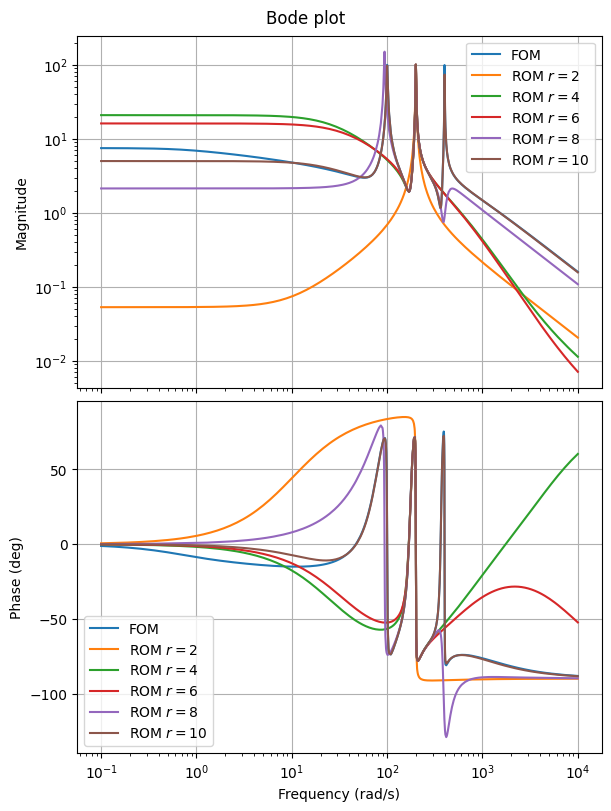

In [15]:
fig, ax = plt.subplots(2, 1, **bode_plot_opts)
fom.transfer_function.bode_plot(w, ax=ax, label='FOM')
for rom in roms_sigma:
    rom.transfer_function.bode_plot(w, ax=ax, label=f'ROM $r = {rom.order}$')
_ = ax[0, 0].legend()
_ = ax[1, 0].legend()

The ROMs are now more accurate around the interpolated frequency, which the error plot also shows.

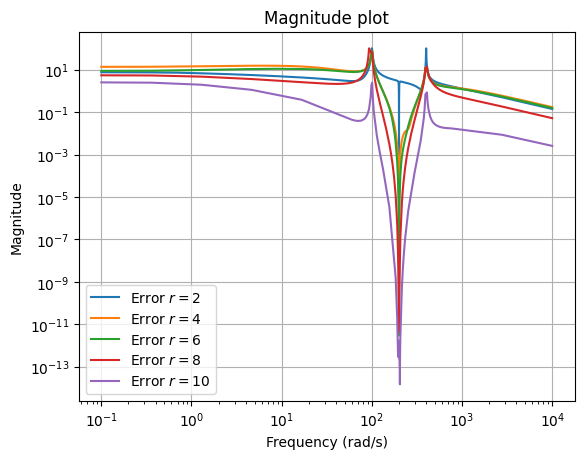

In [16]:
fig, ax = plt.subplots()
for rom in roms_sigma:
    err = fom - rom
    err.transfer_function.mag_plot(w, ax=ax, label=f'Error $r = {rom.order}$')
_ = ax.legend()

The poles of the ROMs are as follows.

Maximum real part: 633.2912934294059


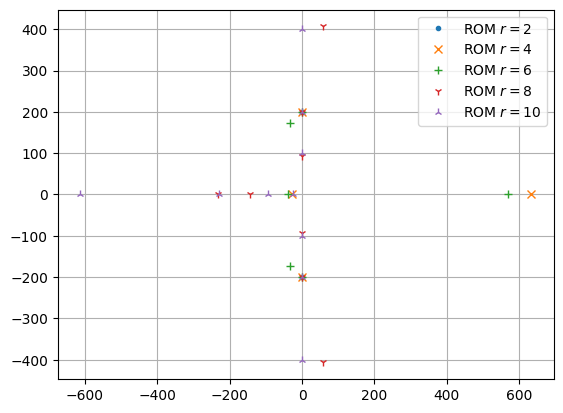

In [17]:
fig, ax = plt.subplots()
spectral_abscissas = []
for rom, marker in zip(roms_sigma, markers):
    poles = rom.poles()
    spectral_abscissas.append(poles.real.max())
    ax.plot(poles.real, poles.imag, marker, label=f'ROM $r = {rom.order}$')
_ = ax.legend()
print(f'Maximum real part: {max(spectral_abscissas)}')

We observe that some of the ROMs are unstable.
In particular, interpolation does not necessarily preserve stability,
just as Petrov-Galerkin projection in general.
A common approach then is using a Galerkin projection with $W = V$ if $A + A^T$
is negative definite.
This preserves stability, but reduces the number of interpolated moments from
$2 r$ to $r$.

## Interpolation at multiple points

To achieve good approximation over a larger frequency range,
instead of local approximation given by higher-order interpolation at a single point,
one idea is to do interpolation at multiple points (sometimes called *multipoint Padé*),
whether of lower or higher-order.
pyMOR implements bitangential Hermite interpolation (BHI) for different types of `Models`,
i.e., methods to construct a reduced-order transfer function $\widehat{H}$ such that

```{math}
\begin{align*}
  H(\sigma_i) b_i & = \widehat{H}(\sigma_i) b_i, \\
  c_i^H H(\sigma_i) & = c_i^H \widehat{H}(\sigma_i), \\
  c_i^H H'(\sigma_i) b_i & = c_i^H \widehat{H}'(\sigma_i) b_i,
\end{align*}
```

for given interpolation points $\sigma_i$,
right tangential directions $b_i$, and
left tangential directions $c_i$,
$i = 1, \ldots, r$.
Such interpolation is relevant for systems with multiple inputs and outputs,
where interpolation of matrices

```{math}
\begin{align*}
  H(\sigma_i) & = \widehat{H}(\sigma_i), \\
  H'(\sigma_i) & = \widehat{H}'(\sigma_i),
\end{align*}
```

may be too restrictive.
Here we focus on single-input single-output systems,
where tangential and matrix interpolation are the same.

Bitangential Hermite interpolation is also relevant for $\mathcal{H}_2$-optimal
model order reduction and methods such as IRKA (iterative rational Krylov
algorithm), but we don't discuss them in this tutorial.

Interpolation at multiple points can be achieved by concatenating different $V$
and $W$ matrices discussed above.
In pyMOR, `LTIBHIReductor` can be used
directly to perform bitangential Hermite interpolation.

In [18]:
import numpy as np
from pymor.reductors.interpolation import LTIBHIReductor

bhi = LTIBHIReductor(fom)
freq = np.array([0.5, 5, 50, 500, 5000])
sigma = np.concatenate([1j * freq, -1j * freq])
b = np.ones((10, 1))
c = np.ones((10, 1))
rom_bhi = bhi.reduce(sigma, b, c)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

We can compare the Bode plots.

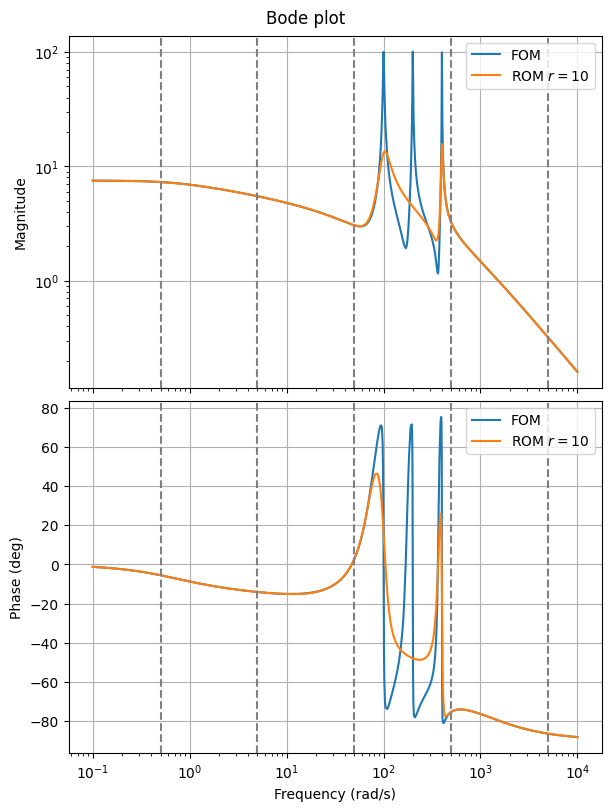

In [19]:
fig, ax = plt.subplots(2, 1, **bode_plot_opts)
fom.transfer_function.bode_plot(w, ax=ax, label='FOM')
rom_bhi.transfer_function.bode_plot(w, ax=ax, label=f'ROM $r = {rom_bhi.order}$')
for a in ax.flat:
    for f in freq:
        a.axvline(f, color='gray', linestyle='--')
    _ = a.legend()

The error plot shows interpolation more clearly.

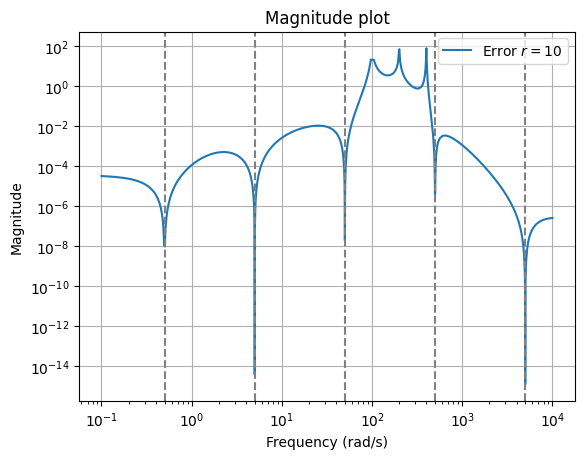

In [20]:
fig, ax = plt.subplots()
err = fom - rom_bhi
err.transfer_function.mag_plot(w, label=f'Error $r = {rom_bhi.order}$')
for f in freq:
    ax.axvline(f, color='gray', linestyle='--')
_ = ax.legend()

We can check stability of the system.

Maximum real part: -1.0071270631815525


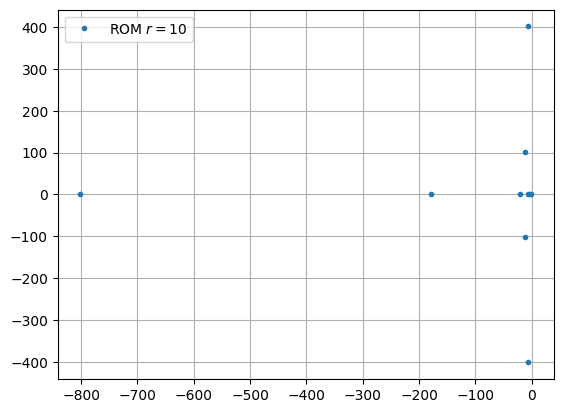

In [21]:
fig, ax = plt.subplots()
poles = rom_bhi.poles()
ax.plot(poles.real, poles.imag, '.', label=f'ROM $r = {rom.order}$')
_ = ax.legend()
print(f'Maximum real part: {poles.real.max()}')

In this case, the ROM is asymptotically stable.

Download the code:
{download}`tutorial_interpolation.md`,
{nb-download}`tutorial_interpolation.ipynb`.